In [52]:
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from read_telega_dump import telega_dump_to_pandas


tlg_group_id = -1001688539638 
# telegram group id, can be taken from "copy message link"  in desctop telegram

### we can use either of the cells below to load data from dump

In [53]:
dump_path = r"D:\test_data\ChatExport_2024-03-14\result.json"
df = telega_dump_to_pandas(dump_path=dump_path)
# note: for data, taken from "export chat history", we do not have number of reactions 


In [54]:
tlg_group_id = -1001688539638
file_path = rf'data\chat{tlg_group_id}.parquet.gzip'
df =pd.read_parquet(file_path)
df.shape

(144835, 10)

In [55]:
df.dtypes

is_question                       bool
user_name                       object
msg_text                        object
msg_len                          int64
reply_to_msg_id                float64
react_cnt                        int64
user_id                          int64
msg_id                           int64
msg_date           datetime64[ns, UTC]
msg_month_key                 category
dtype: object

### Overall statistics

In [56]:
df['dummi'] = 1 # there should be less ugly way to get different aggegations without grouping
agg_df = df.groupby('dummi').aggregate({'msg_id':'count','msg_date':['min','max'], 'user_id': 'nunique'}).reset_index()
msgs_cnt = agg_df[( 'msg_id', 'count')][0]
min_date = agg_df[('msg_date', 'min')][0]
max_date = agg_df[('msg_date', 'max')][0]
number_of_days = (max_date-min_date).days
unique_users =  agg_df[('user_id', 'nunique')][0]
del df['dummi'] 
cols = ["Metric name", "Value"]
dt_format = "%Y-%m-%d"
d_report = [
    {cols[0]: "Number or messages", cols[1]: msgs_cnt},
    {cols[0]: "Date interval", cols[1]: f'from {min_date.strftime(dt_format)} to {max_date.strftime(dt_format)}' },
    {cols[0]: "Users count", cols[1]: unique_users },
    {cols[0]: "Avg messages per day", cols[1]: round(msgs_cnt/number_of_days , 1) },
    ]
pd.DataFrame.from_dict(d_report)






Metric name                          Value
0    Number or messages                         144835
1         Date interval  from 2022-03-05 to 2024-03-20
2           Users count                           1313
3  Avg messages per day                          194.1

### assign date range if you want to restict dataset to some particular period for futher analysis, or just ignore the cell below 

In [57]:
tm_zn = 'Europe/Istanbul'
dt_range = (pd.Timestamp(year=2022, month=2, day=23, tz=tm_zn), pd.Timestamp(datetime.now(), tz=tm_zn))           
number_of_days = (dt_range[1]-dt_range[0]).days
df = df[df.msg_date.between(*dt_range)]


### aggregations by date

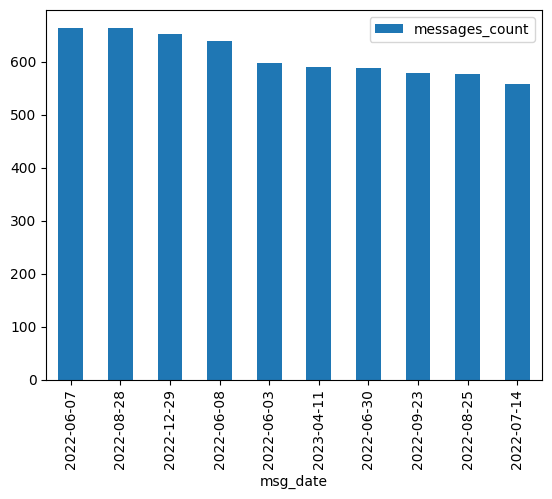

In [58]:
df_aggr = df.groupby(df.msg_date.dt.date).size().sort_values(ascending=False).reset_index(name='messages_count')
df_aggr[0:10].plot(x='msg_date', y='messages_count',kind='bar')
plt.show()

<Axes: >

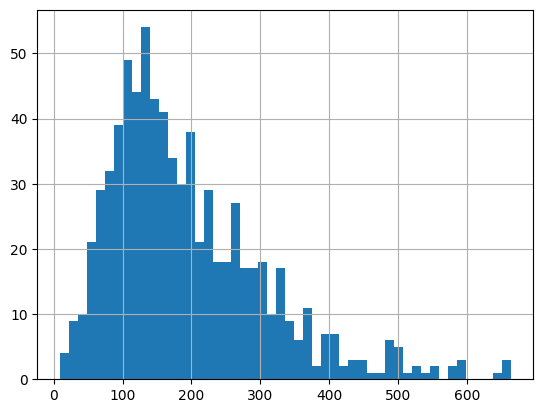

In [59]:
# Visualize the distribution of count of messages per day
df_aggr.messages_count.hist(bins=50)

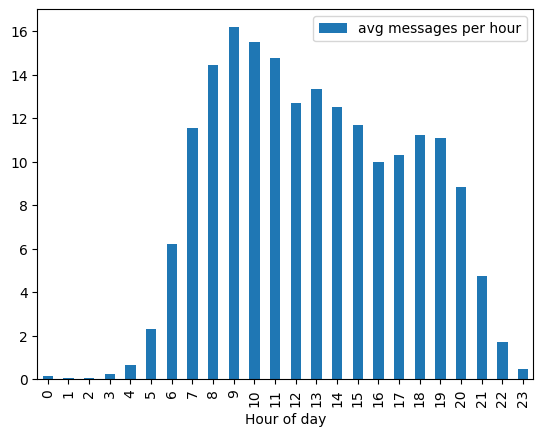

In [60]:
df_aggr = df.groupby(df.msg_date.dt.hour).size().reset_index(name='messages_count')
df_aggr['messages_count'] =  round(df_aggr['messages_count']/number_of_days, 2)
df_aggr = df_aggr.rename(columns={'msg_date': 'Hour of day', 'messages_count': 'avg messages per hour'})
df_aggr[0:24].plot(x='Hour of day', y='avg messages per hour',kind='bar')
plt.show()

### Aggregations by user

Choose metric to play around
- Number of messages
- Length of message
- Number of reactions 
- Number of questions
- Number of answers to some questions


Aggegations

In [61]:
aggs = {'msg_id':'count',
        'msg_date':['min','max'],
        'react_cnt': 'sum',
        'msg_len': 'sum',
        "is_question": 'sum'
        }
agg_df = df.groupby('user_id').aggregate(aggs).reset_index()
agg_df.columns


MultiIndex([(    'user_id',      ''),
            (     'msg_id', 'count'),
            (   'msg_date',   'min'),
            (   'msg_date',   'max'),
            (  'react_cnt',   'sum'),
            (    'msg_len',   'sum'),
            ('is_question',   'sum')],
           )

Calculations for different metrics

In [63]:
# calculations

msg_cnt_s = agg_df[('msg_id', 'count')]

agg_df['activity_days'] = (agg_df [('msg_date', 'max')] - agg_df [('msg_date', 'min')]).dt.days+1
agg_df['reactions_per_mess'] = agg_df[('react_cnt',  'sum')]/msg_cnt_s
agg_df['mess_per_day'] = msg_cnt_s/agg_df['activity_days']
agg_df['len_per_mes'] = agg_df[( 'msg_len', 'sum')]/msg_cnt_s
agg_df['%_of_questions'] = agg_df[('is_question', 'sum')]/msg_cnt_s
agg_df.head(10)

user_id msg_id                  msg_date                            \
           count                       min                       max   
0   20199     10 2022-04-06 14:09:06+00:00 2022-04-16 11:59:02+00:00   
1   59814      5 2022-04-12 19:50:18+00:00 2022-05-16 21:37:42+00:00   
2  249764      1 2023-11-11 09:20:32+00:00 2023-11-11 09:20:32+00:00   
3  259478    205 2022-10-14 17:58:11+00:00 2023-04-15 11:10:23+00:00   
4  268725    235 2022-06-09 12:19:08+00:00 2022-12-21 16:09:06+00:00   
5  285150      1 2022-05-08 12:05:18+00:00 2022-05-08 12:05:18+00:00   
6  345383      4 2022-11-10 11:14:12+00:00 2023-02-06 21:51:33+00:00   
7  361816      8 2022-06-30 11:16:33+00:00 2022-07-13 08:05:39+00:00   
8  555411   1218 2022-05-22 06:36:08+00:00 2024-03-19 12:01:52+00:00   
9  713052      4 2022-11-07 07:25:20+00:00 2023-09-01 17:06:07+00:00   

  react_cnt msg_len is_question activity_days reactions_per_mess mess_per_day  \
        sum     sum         sum                                                 
0         1     433           4            10           0.100000     1.000000   
1         4     697           0            35           0.800000     0.142857   
2         1      21           0             1           1.000000     1.000000   
3        51   13789          34           183           0.248780     1.120219   
4        59   12584          67           196           0.251064     1.198980   
5         0     202           1             1           0.000000     1.000000   
6         0     361           3            89           0.000000     0.044944   
7         1     540           3            13           0.125000     0.615385   
8       453  108564         304           668           0.371921     1.823353   
9         1    1793           0           299           0.250000     0.013378   

  len_per_mes %_of_questions  
                              
0   43.300000       0.400000  
1  139.400000       0.000000  
2   21.000000       0.000000  
3   67.263415       0.165854  
4   53.548936       0.285106  
5  202.000000       1.000000  
6   90.250000       0.750000  
7   67.500000       0.375000  
8   89.133005       0.249589  
9  448.250000       0.000000

In [64]:
agg_df

user_id msg_id                  msg_date                            \
                  count                       min                       max   
0          20199     10 2022-04-06 14:09:06+00:00 2022-04-16 11:59:02+00:00   
1          59814      5 2022-04-12 19:50:18+00:00 2022-05-16 21:37:42+00:00   
2         249764      1 2023-11-11 09:20:32+00:00 2023-11-11 09:20:32+00:00   
3         259478    205 2022-10-14 17:58:11+00:00 2023-04-15 11:10:23+00:00   
4         268725    235 2022-06-09 12:19:08+00:00 2022-12-21 16:09:06+00:00   
...          ...    ...                       ...                       ...   
1308  6034228449      1 2024-03-11 09:48:16+00:00 2024-03-11 09:48:16+00:00   
1309  6038053524      9 2023-09-05 06:37:25+00:00 2023-11-06 14:03:53+00:00   
1310  6038264334     45 2024-03-05 11:49:57+00:00 2024-03-05 16:10:36+00:00   
1311  6258774855    248 2023-04-04 13:19:51+00:00 2024-03-16 07:42:27+00:00   
1312  6281610969      4 2023-08-04 06:25:09+00:00 2023-11-18 06:49:50+00:00   

     react_cnt msg_len is_question activity_days reactions_per_mess  \
           sum     sum         sum                                    
0            1     433           4            10           0.100000   
1            4     697           0            35           0.800000   
2            1      21           0             1           1.000000   
3           51   13789          34           183           0.248780   
4           59   12584          67           196           0.251064   
...        ...     ...         ...           ...                ...   
1308         0     296           0             1           0.000000   
1309         0     933           5            63           0.000000   
1310         6   31496           8             1           0.133333   
1311       125   31889          42           347           0.504032   
1312         1    1666           1           107           0.250000   

     mess_per_day len_per_mes %_of_questions  
                                              
0        1.000000   43.300000       0.400000  
1        0.142857  139.400000       0.000000  
2        1.000000   21.000000       0.000000  
3        1.120219   67.263415       0.165854  
4        1.198980   53.548936       0.285106  
...           ...         ...            ...  
1308     1.000000  296.000000       0.000000  
1309     0.142857  103.666667       0.555556  
1310    45.000000  699.911111       0.177778  
1311     0.714697  128.584677       0.169355  
1312     0.037383  416.500000       0.250000  

[1313 rows x 12 columns]

In [68]:
rank_metricks = [
     ('msg_id', 'count'),
     ('msg_len',   'sum'),
     ('reactions_per_mess',''),    
]
for m in rank_metricks:
   agg_df['rn_' + m[0]] = agg_df[m].rank(ascending=False).astype('int')


In [67]:
agg_df['RN'] = agg_df['mess_per_day'].rank(ascending=False).astype('int')

0        889
1         71
2         39
3        598
4        558
        ... 
1308    1138
1309    1138
1310     827
1311     133
1312     578
Name: (reactions_per_mess, ), Length: 1313, dtype: int32